# Mitsubishi reverse cycle heat pump

In [ ]:
from Modules.Heating import Heat_Pump
import matplotlib.pyplot as plt
import Modules.Data as Data
import numpy as np

Heat_Pump = Heat_Pump("Data/Heat_Pump/EAHV-M1500-YCL(-N)/Heating_5C.csv")

COP_interp = Heat_Pump.interp_init("COP")

air_temp = np.linspace(-20, 25, 1000)
hydronics_temp = [25, 30, 35, 40, 45, 47.5, 50, 52.5, 55]

for output_temp in hydronics_temp:

    COP = Heat_Pump.Calculate_COP(output_temp, air_temp, COP_interp)
    
    plt.plot(air_temp, COP, label = 'Flow temp ' + str(output_temp) + '°C')
    
# data points
data_air_temp = Data.column_from_csv("Data/Heat_Pump/EAHV-M1500-YCL(-N)/Heating_5C.csv", "Air temperature(°C)")

data_flow_temp = Data.column_from_csv("Data/Heat_Pump/EAHV-M1500-YCL(-N)/Heating_5C.csv", "Flow temperature(°C)") 

data_COP = Heat_Pump.Calculate_COP(data_flow_temp, data_air_temp, COP_interp)

plt.plot(data_air_temp, data_COP, label="data points", marker='x', color='red', linestyle='None')

plt.title('Coefficient of performance for a heat pump')
plt.xlabel('Air temperature(°C)')
plt.ylabel('COP')
plt.legend()

ValueError: RHS must contain only finite numbers

Number of fan coils required: 64
[305.   305.   305.   305.   305.   305.   305.   305.   305.   305.
 305.   305.   305.   305.   299.02 286.4  305.   305.   305.   281.39
 305.   305.   305.   305.   225.47 305.   305.   305.   305.   305.
 305.   305.   305.   305.   305.   305.   305.   305.   305.   305.
 305.   305.   305.   305.   305.   305.   305.   293.82 284.1  305.
 305.   305.   305.   305.   305.   290.7  291.69 273.84 276.64 283.23
 297.73 304.44 302.68 304.5  305.   305.   305.   305.   305.   305.
 305.   305.   305.   305.   305.   305.   305.   305.   305.   286.74
 305.   298.98 305.   305.   305.   305.   305.   305.   297.56 305.
 305.   305.   305.   305.   305.   300.46 282.29 305.   305.   305.
 305.   281.59 305.   305.   305.   305.   285.68 305.   305.   305.
 305.   305.   305.   305.   305.   305.   305.   305.   305.   305.
 305.   305.   305.   305.   305.   305.   273.25 251.42 270.06 281.68
 281.39 296.43]
[nan nan nan nan nan nan nan nan nan nan nan n

Text(0, 0.5, 'Capped heating requirement (kW)')

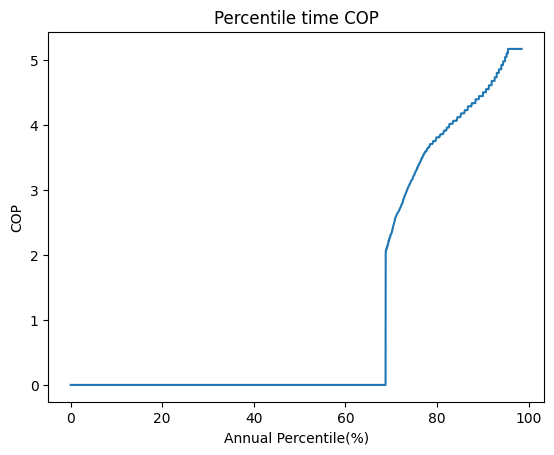

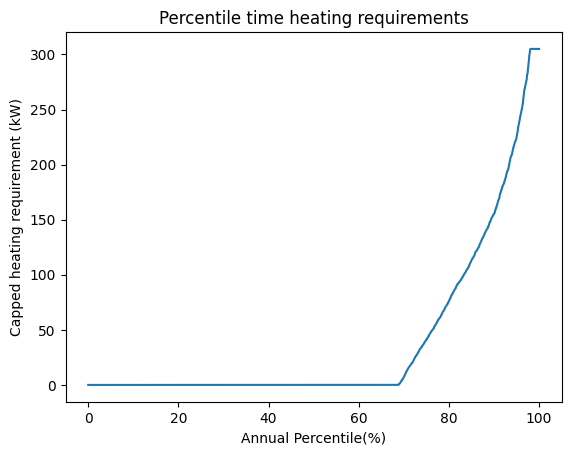

In [ ]:
from Modules.Heating import Heat_Pump
from Modules.Heating import HVAC
from Modules.Heating import Reverse_HP_Controller
from Modules.Heating import Heating_Distribution
import numpy as np
import matplotlib.pyplot as plt

max_HP_power = 305 # in kW
max_HVAC_power = 175 # in kW
# max_hydronics_temp = 55 # based off of operating conditions of heat pump

Heat_Pump = Heat_Pump("Data/Heat_Pump/EAHV-M1500-YCL(-N)/Heating_5C.csv")
HVAC = HVAC("Data/Heat_Pump/EAHV-M1500-YCL(-N)/Cooling_5C.csv")

Heating_Distribution = Heating_Distribution("Data/HFP-550LM-Z1", max_HP_power, max_HVAC_power)

Controller = Reverse_HP_Controller(Heat_Pump, HVAC, Heating_Distribution, max_HP_power, max_HVAC_power)

(
    time, air_temp,
    heating, heating_electricity, heating_hydronics_temp, COP,
    cooling, cooling_electricity, cooling_hydronics_temp, EER
) = Controller.controller()

indices = [i for i, x in enumerate(heating_electricity) if np.isnan(x)]

# HP system
print('Total heating electricity usage ' + str(np.sum(heating_electricity)) + ' kWh/yr')

effective_COP = np.sum(heating) / np.sum(heating_electricity)
print('Effective COP: ' + str(effective_COP))

# HVAC system
print('Total cooling electricity usage ' + str(np.sum(cooling_electricity)) + ' kWh/yr')

effective_EER = np.sum(cooling) / np.sum(cooling_electricity)
print('Effective EER: ' + str(effective_EER))

# Plotting stuff - maybe don't need now?

# When heating is zero set COP to 0
indices = [i for i, x in enumerate(heating) if x == 0]
COP[indices] = 0

plt.figure(0)
plt.plot(100 * time / np.max(time), np.sort(COP))
plt.title("Percentile time COP")
plt.xlabel('Annual Percentile(%)')
plt.ylabel('COP')
plt.figure(3)
plt.plot(100 * time / np.max(time), np.sort(heating))
plt.title('Percentile time heating requirements')
plt.xlabel('Annual Percentile(%)')
plt.ylabel('Capped heating requirement (kW)')